### MLP-pitmodel

base: MLP-pitmodel-plen2

build a pitstop dataset with <cautions_laps, pitage, gap2nextpit>
gluonts interface of Dataset = Iterable[DataEntry], DataEntry = Dict(str, any)

+ input pitstop dataset, remove pitstops with pit_oncaution = 1, refer to lapstatus_dataset-fastrun
+ context_length = 1, prediction_length = 1
+ target : gap to nextpit
+ covariates are: cautions_laps, pitage, (carid, eid)
+ modeling the distribution of nextpit-gap


In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os,sys
import random
import mxnet as mx
from mxnet import gluon
import pickle
import json
from gluonts.dataset.common import ListDataset
from gluonts.dataset.util import to_pandas
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

import inspect
from scipy import stats
from pathlib import Path 
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from gluonts.dataset.util import to_pandas
from pathlib import Path
from gluonts.trainer import Trainer
from gluonts.evaluation.backtest import make_evaluation_predictions
from gluonts.evaluation import Evaluator, MultivariateEvaluator
from gluonts.model.predictor import Predictor
from gluonts.distribution.neg_binomial import NegativeBinomialOutput
from gluonts.distribution.student_t import StudentTOutput
from gluonts.model.forecast import SampleForecast

from indycar.model.mlp import MLPEstimator

INFO:root:Using GPU


In [2]:
import os
os.getcwd()

'/scratch_hdd/hpda/indycar/notebook/22.PaperFinal'

In [3]:

def nan_helper(y):
    """Helper to handle indices and logical indices of NaNs.

    Input:
        - y, 1d numpy array with possible NaNs
    Output:
        - nans, logical indices of NaNs
        - index, a function, with signature indices= index(logical_indices),
          to convert logical indices of NaNs to 'equivalent' indices
    Example:
        >>> # linear interpolation of NaNs
        >>> nans, x= nan_helper(y)
        >>> y[nans]= np.interp(x(nans), x(~nans), y[~nans])
    """

    return np.isnan(y), lambda z: z.nonzero()[0]

def test_flag(a, bitflag):
    return (a & bitflag) ==  bitflag

#
# remove NaN at the tail
# there should be no nans in the middle of the ts
COL_LAPTIME=0
COL_RANK=1
COL_TRACKSTATUS=2
COL_LAPSTATUS=3
COL_TIMEDIFF=4
COL_CAUTION_LAPS_INSTINT=5
COL_LAPS_INSTINT= 6
COL_ELAPSED_TIME= 7
COL_LAP2NEXTPIT = 8


MODE_ORACLE = 0
MODE_NOLAP = 1
MODE_NOTRACK = 2
MODE_TESTZERO = 4
MODE_TESTCURTRACK = 8
#MODE_STR={MODE_ORACLE:'oracle', MODE_NOLAP:'nolap',MODE_NOTRACK:'notrack',MODE_TEST:'test'}

def split_ts(rec, carno, eid):
    """
    input: 
        ts
    output:
        nextpit records
    """
    output = []
    pitstops = np.where(rec[COL_LAPSTATUS,:] == 1)[0]
    
    if len(pitstops)==0:
        print('no pit ts')
        return output
    
    #pit_oncaution = np.zeros_like((pitstops))
    #for pit in pitstops:
    #    if rec[COL_TRACKSTATUS,:] == 1:
    #        pit_oncaution = 1
    pit_oncaution = np.zeros_like((rec[COL_LAP2NEXTPIT,:]))
    stint_len = np.zeros_like((rec[COL_LAP2NEXTPIT,:]))
    pos = 0
    for pit in pitstops:
        if rec[COL_TRACKSTATUS,pit] == 1:
            #next pit is oncaution
            # set pos -> pit as oncaution
            pit_oncaution[pos:pit] = 1
        else:
            pit_oncaution[pos:pit] = 0
            
        stint_len[pos:pit] = pit - pos
        pos = pit
        
            
    #prepare output : lap2nextpit, CAUTION_LAPS_INSTINT,LAPS_INSTINT, pit_oncaution, carno, eid, lap, stintlen
    totallen = pitstops[-1]
    #output = np.zeros((totallen, 6 ))
    #for idx in range(totallen):
    #    output[idx, 0] = rec[COL_LAP2NEXTPIT ,idx]
    #    output[idx, 1] = rec[COL_CAUTION_LAPS_INSTINT ,idx]
    #    output[idx, 2] = rec[COL_LAPS_INSTINT ,idx]
    #    output[idx, 3] = pit_oncaution[idx]
    #    output[idx, 4] = carno
    #    output[idx, 5] = eid
        
    for idx in range(totallen):
        output.append([ rec[COL_LAP2NEXTPIT ,idx]
                        ,rec[COL_CAUTION_LAPS_INSTINT ,idx]
                        ,rec[COL_LAPS_INSTINT ,idx]
                        ,pit_oncaution[idx]
                        ,carno
                        ,eid
                        ,idx
                        ,stint_len[idx]
                      ])
        
    return output

def make_dataset_byevent(test_event = 'Indy500-2018'):
    """
    split the ts to train and test part by the ratio
    
    oracle_mode: false to simulate prediction in real by 
        set the covariates of track and lap status as nan in the testset
            
    
    """    
    useeid = False
    run_ts = COL_LAP2NEXTPIT
    train_set = []
    test_set = []
    
    #_data: eventid, carids, datalist[carnumbers, features, lapnumber]->[laptime, rank, track, lap]]
    for _data in laptime_data:
        _train = []
        _test = []
        
        if events[_data[0]] == test_event:
            test_mode = True
        else:
            test_mode = False
            
        # process for each ts
        for rowid in range(_data[2].shape[0]):
            # rec[features, lapnumber] -> [laptime, rank, track_status, lap_status,timediff]]
            rec = _data[2][rowid].copy()
            
            #remove nan(only tails)
            nans, x= nan_helper(rec[run_ts,:])
            nan_count = np.sum(nans)             
            rec = rec[:, ~np.isnan(rec[run_ts,:])]
            
            # remove short ts
            totallen = rec.shape[1]
            
            carno = _data[1][rowid]
            carid = global_carids[_data[1][rowid]]
            
            eid = _data[0]
            
            # all go to train set
            output = split_ts(rec, carno, eid)
            #if len(output) == 0:
            #    continue
            
            test_rec_cnt = 0
            if not test_mode:
                _train.extend(output)
                
            else:
                _test.extend(output)
                test_rec_cnt += 1
            
            #add one ts
            print(f'carno:{carno}, totallen:{totallen}, nancount:{nan_count}, test_reccnt:{test_rec_cnt}')

        train_set.extend(_train)
        test_set.extend(_test)

    print(f'train len:{len(train_set)}, test len:{len(test_set)}')
    
    return train_set, test_set

def save_dataset(datafile,freq, prediction_length, cardinality, train_ds, test_ds):
    with open(datafile, 'wb') as f:
        #pack [global_carids, laptime_data]
        savedata = [freq, prediction_length, cardinality, train_ds, test_ds]
        #savedata = [freq, train_set, test_set]
        # Pickle the 'data' dictionary using the highest protocol available.
        pickle.dump(savedata, f, pickle.HIGHEST_PROTOCOL)

### create dbs

In [4]:
_inlap_status = 0
#years = ['2013','2014','2015','2016','2017','2018','2019']
years = ['2013','2014','2015','2016','2017','2018','2019']
#events = ['Indy500']
events = [f'Indy500-{x}' for x in years]
events_id={key:idx for idx, key in enumerate(events)}
dbid = f'Indy500_{years[0]}_{years[-1]}_v9_p{_inlap_status}'
testevent = 'Indy500-2018'
# start from here
import pickle
#with open('laptime_rank_timediff_fulltest-oracle-%s.pickle'%year, 'rb') as f:
with open(f'laptime_rank_timediff_pit-oracle-{dbid}.pickle', 'rb') as f:
    # The protocol version used is detected automatically, so we do not
    # have to specify it.
    global_carids, laptime_data = pickle.load(f, encoding='latin1') 

In [5]:
train, test =  make_dataset_byevent(test_event = 'Indy500-2018')
#prepare output : lap2nextpit, CAUTION_LAPS_INSTINT,LAPS_INSTINT, pit_oncaution, carno, eid, lap
df_train = pd.DataFrame(train,columns=['lap2nextpit', 'caution_laps','pitage', 'pit_oncaution', 
                 'carno','eid','lap','stint_len'])
df_test = pd.DataFrame(test,columns=['lap2nextpit', 'caution_laps','pitage', 'pit_oncaution', 
                 'carno','eid','lap','stint_len'])



carno:1, totallen:200, nancount:0, test_reccnt:0
carno:2, totallen:200, nancount:0, test_reccnt:0
carno:3, totallen:200, nancount:0, test_reccnt:0
no pit ts
carno:4, totallen:0, nancount:200, test_reccnt:0
carno:5, totallen:200, nancount:0, test_reccnt:0
no pit ts
carno:6, totallen:30, nancount:170, test_reccnt:0
carno:7, totallen:177, nancount:23, test_reccnt:0
carno:8, totallen:200, nancount:0, test_reccnt:0
carno:9, totallen:200, nancount:0, test_reccnt:0
carno:10, totallen:187, nancount:13, test_reccnt:0
carno:11, totallen:200, nancount:0, test_reccnt:0
carno:12, totallen:200, nancount:0, test_reccnt:0
carno:14, totallen:200, nancount:0, test_reccnt:0
carno:15, totallen:170, nancount:30, test_reccnt:0
carno:16, totallen:179, nancount:21, test_reccnt:0
carno:18, totallen:200, nancount:0, test_reccnt:0
carno:19, totallen:200, nancount:0, test_reccnt:0
carno:20, totallen:200, nancount:0, test_reccnt:0
carno:21, totallen:170, nancount:30, test_reccnt:0
carno:22, totallen:200, nancount:

In [6]:
datafile = f'pitstop_nextpit_dataset-{dbid}-t{testevent}.pickle'
with open(datafile, 'wb') as f:
    savedata = [df_train, df_test, events, testevent]
    pickle.dump(savedata, f, pickle.HIGHEST_PROTOCOL)

In [7]:
df_train

,lap2nextpit,caution_laps,pitage,pit_oncaution,carno,eid,lap,stint_len
0,30.0,0.0,1.0,0.0,1,0,0,30.0
1,29.0,0.0,2.0,0.0,1,0,1,30.0
2,28.0,0.0,3.0,0.0,1,0,2,30.0
3,27.0,1.0,4.0,0.0,1,0,3,30.0
4,26.0,2.0,5.0,0.0,1,0,4,30.0
...,...,...,...,...,...,...,...,...
30279,2.0,0.0,0.0,1.0,98,6,174,2.0
30280,1.0,1.0,1.0,1.0,98,6,175,2.0
30281,2.0,0.0,0.0,1.0,98,6,176,2.0
30282,1.0,1.0,1.0,1.0,98,6,177,2.0


In [8]:
#make gluonts
from sklearn.preprocessing import StandardScaler,MinMaxScaler

def makedb(data, scaler='standard', perm = True):
    db = []
    start = pd.Timestamp("01-01-2019", freq='1min')  # can be different for each time series
    
    scalers = {'minmax':MinMaxScaler(), 'standard':StandardScaler()}
    
    if isinstance(scaler, str):
        if scaler in scalers:
            scaler = scalers[scaler]
            scaler.fit(data)
            df = scaler.transform(data)
        else:
            # no scaler
            df = data
    else:
        #use input scaler
        #scaler.fit(data)
        df = scaler.transform(data)
        
    
    #permute
    if perm:
        perm = np.random.permutation(len(df))
        df = df[perm]
    
    for x in df:
        
        #db.append({'target':np.array(x[0]), 'feat':[np.array(x[1]),np.array(x[2])]})
        db.append({'target':np.array([x[0]]), 'feat':np.array([x[1],x[2]]),
                  "start":start, 'forecast_start':start})
        #db.append({'target':np.array(x[0]).reshape((1,-1)), 'feat':[np.array(x[1]).reshape((1,-1)),np.array(x[2]).reshape((1,-1))]})
        
    return db, scaler, df


In [9]:
def make_fulltestdb(scaler, maxgap=60):
    db = []
    start = pd.Timestamp("01-01-2019", freq='1min')  # can be different for each time series

    data = []
    for caution_lap in range(maxgap):
        for pitage in range(caution_lap, maxgap):
            data.append([0.,caution_lap, pitage ])
    data = np.array(data)
    
    if not isinstance(scaler, str):
        df = scaler.transform(data)
    else:
        df = data
    
    #data
    print(f'make full testdb: {len(df)} records')
    for x in df:
        db.append({'target':np.array([x[0]]), 'feat':np.array([x[1],x[2]]),
                  "start":start, 'forecast_start':start})
            
    return db, scaler, df, data

In [10]:
train_sel = df_train[(df_train['pit_oncaution']==0) &(df_train['stint_len']>23)]
train_sel_2013_2017 = train_sel[train_sel['eid']<5]
train_all_2013_2017 = df_train[df_train['eid']<5]

print(len(train_all_2013_2017), len(train_sel_2013_2017))    

test_sel = df_test[(df_test['pit_oncaution']==0) &(df_test['stint_len']>23)]
test_all = df_test

#test_all = df_test[(df_test['stint_len']>23)]
#datafile = f'pitstop_nextpit_dataset-{dbid}-t{testevent}-sel.pickle'
#with open(datafile, 'wb') as f:
#    savedata = [train_sel, test_sel, events, testevent]
#    pickle.dump(savedata, f, pickle.HIGHEST_PROTOCOL)
#    
#print(len(train_sel), len(test_sel))    

24973 13976


In [11]:
_data = {}
#model store
p, t, s, e = {}, {} ,{}, {}

# negbin, use no sclaer
#train_ds, scaler = makedb(train_sel[['lap2nextpit','caution_laps','pitage']].values, scaler='')
#train_ds, scaler = makedb(train_sel[['lap2nextpit','caution_laps','pitage']].values, scaler='minmax')
train_ds, scaler, train_set = makedb(train_sel[['lap2nextpit','caution_laps','pitage']].values, scaler='standard')
test_ds, _, test_set = makedb(test_sel[['lap2nextpit','caution_laps','pitage']].values, scaler, perm=False)

# selected db
trainset = train_sel_2013_2017[['lap2nextpit','caution_laps','pitage']].values
testset = test_sel[['lap2nextpit','caution_laps','pitage']].values
train_ds, scaler, _ = makedb(trainset, scaler='standard')
test_ds, _, _ = makedb(testset, scaler, perm=False)

_data['sel'] = [trainset, testset, train_ds, test_ds, scaler]


# selected db
trainset = train_all_2013_2017[['lap2nextpit','caution_laps','pitage']].values
testset = test_all[['lap2nextpit','caution_laps','pitage']].values
train_ds, scaler, _ = makedb(trainset, scaler='standard')
test_ds, _, _ = makedb(testset, scaler, perm=False)

_data['all'] = [trainset, testset, train_ds, test_ds, scaler]


In [27]:
datafile = f'pitstop_nextpit_dataset-{dbid}-t{testevent}-alldata.pickle'
with open(datafile, 'wb') as f:
    savedata = [df_train, df_test, events, testevent, _data]
    pickle.dump(savedata, f, pickle.HIGHEST_PROTOCOL)

### train

In [12]:
def train_model(epochs, layers=[10,10,5], output = 'student', dropout = .5, id='all'):
    distr_outputs ={'student':StudentTOutput(),  
                    'negbin':NegativeBinomialOutput() 
                   }
    if not output in distr_outputs:
        print(f'distr_output: {output} not found error.')
        return
    
    distr_output = distr_outputs[output]
    
    modelid = 'mlp-d%s-e%s-l%s-%s-d%s'%(id, epochs, '-'.join([str(x) for x in layers]), output, dropout)
    
    estimator = MLPEstimator(
        num_hidden_dimensions=layers,
        prediction_length=1,
        context_length=1,
        freq='1min',
        dropout = dropout,
        distr_output = distr_output,
        trainer=Trainer(ctx="gpu(0)", 
                        batch_size = 32,
                        epochs= epochs,
                        learning_rate=1e-3,
                        hybridize=False,
                        num_batches_per_epoch=100
                       )
    )    

    predictor = estimator.train(train_ds)

    return predictor, modelid

In [13]:
def eval_model(predictor, test_ds):
    forecast_it, ts_it = make_evaluation_predictions(
        dataset=test_ds,  # test dataset    
        predictor=predictor,  # predictor                                  
        num_samples=1000,  # number of sample paths we want for evaluation 
    )

    forecasts = list(forecast_it)
    tss = list(ts_it)     
    evaluator = Evaluator(quantiles=[0.1, 0.5, 0.9]) 
    agg_metrics, item_metrics = evaluator(iter(tss), iter(forecasts), num_series=len(test_ds))
    print(json.dumps(agg_metrics, indent=4)) 
    return tss, forecasts, agg_metrics


def raw_eval(tss, forecasts):
    """
    scaler
    """
    rec = np.zeros((3))

    truth, pred = [],[]
    #go through the dataset
    for idx in range(len(tss)):
        rec[0] = list(tss[idx].values)[0]
    
        if isinstance(scaler, str):
            truth.append(int(rec[0]))
        else:
            truth.append(int(scaler.inverse_transform(rec)[0]))
    
        rec[0] = np.mean(forecasts[idx].samples)
        
        if isinstance(scaler, str):
            pred.append(int(rec[0]))    
        else:
            pred.append(int(scaler.inverse_transform(rec)[0]))        

    #get mae
    mae = mean_absolute_error(truth, pred)
    print('mae = ', mae)
    return mae
    

def save_model(predictor, outdir):
    if not os.path.exists(outdir):
        os.mkdir(outdir)
    
    predictor.serialize(Path(outdir)) 

def get_pred(tss, forecasts, idx,raw_forecast = False):
    rec = np.zeros((3))
    rec[0] = list(tss[idx].values)[0]
    
    if isinstance(scaler, str):
        truth = int(rec[0])
    else:
        truth = int(scaler.inverse_transform(rec)[0])
    
    ret = []
    for sample in forecasts[idx].samples:
        rec[0] = sample
        if isinstance(scaler, str) or raw_forecast:
            ret.append(int(rec[0]))    
        else:
            ret.append(int(scaler.inverse_transform(rec)[0]))    
        
    print('idx:', idx, 't:', truth, 'p:', int(np.mean(ret)))
    plt.hist(ret, bins=range(min(ret),max(ret)+1), alpha=0.7, label='%s'%idx)
    return truth, ret

def run_test(tss, forecasts, testlist, raw_forecast = False):
    for idx in testlist:
        get_pred(tss, forecasts, idx, raw_forecast)
    plt.legend()

In [14]:
### pitmodel
class PitModel():
    """
     <caution_lap, pitage> -> [distribution]    
     distribution := sorted cdf [val:probability, val2:p2, ...]
         [0,:] -> val
         [1,:] -> cdf p
         
     no scaler, raw feat and target
    
    """
    def __init__(self, modelfile=''):
        self.model = {}
        self.name = ''
        
        if modelfile:
            self.load_model(modelfile)
                
    def load_model(self, modelfile):
        with open(modelfile, 'rb') as f:
            self.name, self.model = pickle.load(f, encoding='latin1')
            print(f'init model:{self.name}')
        
    def save_model(self, modelname, test_ds, forecasts, scaler):
        
        model = {}
        
        #get the sclaer for the first column(lap2nextpit)
        sc, scf = '', ''
        if isinstance(scaler, StandardScaler):
            sc = StandardScaler()
            sc.scale_ = scaler.scale_[0]
            sc.mean_ = scaler.mean_[0]
            sc.var_ = scaler.var_[0]

            scf = StandardScaler()
            scf.scale_ = scaler.scale_[1:]
            scf.mean_ = scaler.mean_[1:]
            scf.var_ = scaler.var_[1:]

        
        for idx, rec in enumerate(test_ds):
            feat = rec[1:]
                
            key = '-'.join([str(int(x)) for x in feat])
            
            if not key in model:
            
                samples = forecasts[idx].samples.reshape(-1)
                
                if not isinstance(sc, str):
                    samples = sc.inverse_transform(samples)
                
                #force to prediction to be valid lap2nextpit
                samples = samples.astype(int)
                samples = samples[samples > 0]

                #
                valset = set(list(samples))
                plen = len(valset)
                distr = np.zeros((2, plen))
                distr[0, :] = sorted(valset)
                smap = {val:id for id, val in enumerate(distr[0, :])}
                for s in samples:
                    distr[1,smap[s]] += 1
                tsum = np.sum(distr[1,:])
                distr[1, :] /= tsum
                distr[1, :] = np.cumsum(distr[1, :])

                model[key] = distr
                
        #save model
        self.model = model
        self.name = modelname
        with open(modelname, 'wb') as f:
            savedata = [self.name, self.model]
            pickle.dump(savedata, f, pickle.HIGHEST_PROTOCOL)        
        print(f'save model {modelname} with {len(self.model)} keys.')
                
    def predict(self, *args):
        key = '-'.join([str(int(x)) for x in args])
        #if key in self.model:
        try:
            distr = self.model[key]
            
            #[0, 1.)
            p = np.random.random()  
            i = np.sum(distr[1,:] < p)
            
            return distr[0,i]
        except:
            #exception
            #todo, backto special model
            print(f'ERROR: key {key} not found in model')
                       
    def forecast_ds(self, test_ds, forecasts):
        """
        test_ds as testset, the unsclaed input
        forecasts ; the template
        """
        
        plen = len(test_ds)
        sample_cnt = forecasts[0].samples.shape[0]
        assert(plen == len(forecasts))
        

        #build a new forecasts object
        nf = []
        for fc in forecasts:
            nfc = SampleForecast(samples = np.zeros_like(fc.samples), 
                                 freq=fc.freq, start_date=fc.start_date)
            nf.append(nfc)
        
        for idx, rec in enumerate(test_ds):
            feat = rec[1:]
                    
            onecast = np.zeros((sample_cnt))
            for i in range(sample_cnt):
                onecast[i] = self.predict(feat[0], feat[[1]])
        
            nf[idx].samples = onecast

        return nf
    

def save_full_pitmodel(mid, runid, maxgap=60):
    """
    input:
        p[mid]; predictor
        runid ; 'all' or 'sel' of the trainning set
    """
    
    #get scaler
    scaler = _data[runid][4]

    # make full test set
    test_ds, _, _, test_all = make_fulltestdb(scaler, maxgap = maxgap)

    tss,forecasts, _ = eval_model(p[mid], test_ds)

    pitmodel = PitModel()

    #pitmodel.save_model(f'pitmodel-m{maxgap}-{mid}.pickle', test_all, forecasts, scaler)
    pitmodel.save_model(f'pitmodel-m{maxgap}-{mid}-1k.pickle', test_all, forecasts, scaler)


### best model output

In [26]:
#trainset, testset, train_ds, test_ds, scaler = _data['all']
trainset, testset, train_ds, test_ds, scaler = _data['sel']

INFO:root:Start model training
INFO:root:Epoch[0] Learning rate is 0.001
100%|██████████| 100/100 [00:00<00:00, 168.94it/s, avg_epoch_loss=1.07]
INFO:root:Epoch[0] Elapsed time 0.593 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=1.069769
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 100/100 [00:00<00:00, 174.99it/s, avg_epoch_loss=0.784]
INFO:root:Epoch[1] Elapsed time 0.573 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=0.783655
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 100/100 [00:00<00:00, 173.22it/s, avg_epoch_loss=0.592]
INFO:root:Epoch[2] Elapsed time 0.579 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=0.591794
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 100/100 [00:00<00:00, 176.57it/s, avg_epoch_loss=0.393]
INFO:root:Epoch[3] Elapsed time 0.568 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=0.393120
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 100/100 [00:00<00:00, 176.03it/

100%|██████████| 100/100 [00:00<00:00, 173.23it/s, avg_epoch_loss=0.0417]
INFO:root:Epoch[72] Elapsed time 0.579 seconds
INFO:root:Epoch[72] Evaluation metric 'epoch_loss'=0.041716
INFO:root:Epoch[73] Learning rate is 0.0005
100%|██████████| 100/100 [00:00<00:00, 173.66it/s, avg_epoch_loss=0.0242]
INFO:root:Epoch[73] Elapsed time 0.577 seconds
INFO:root:Epoch[73] Evaluation metric 'epoch_loss'=0.024174
INFO:root:Epoch[74] Learning rate is 0.0005
100%|██████████| 100/100 [00:00<00:00, 173.68it/s, avg_epoch_loss=-.00154]
INFO:root:Epoch[74] Elapsed time 0.577 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=-0.001536
INFO:root:Epoch[75] Learning rate is 0.0005
100%|██████████| 100/100 [00:00<00:00, 170.29it/s, avg_epoch_loss=-.00937]
INFO:root:Epoch[75] Elapsed time 0.588 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=-0.009367
INFO:root:Epoch[76] Learning rate is 0.0005
100%|██████████| 100/100 [00:00<00:00, 162.61it/s, avg_epoch_loss=0.0398]
INFO:root:Epoch[76] El

INFO:root:Epoch[108] Learning rate is 0.000125
100%|██████████| 100/100 [00:00<00:00, 170.26it/s, avg_epoch_loss=-.0398]
INFO:root:Epoch[108] Elapsed time 0.589 seconds
INFO:root:Epoch[108] Evaluation metric 'epoch_loss'=-0.039819
INFO:root:Epoch[109] Learning rate is 0.000125
100%|██████████| 100/100 [00:00<00:00, 165.13it/s, avg_epoch_loss=-.00802]
INFO:root:Epoch[109] Elapsed time 0.607 seconds
INFO:root:Epoch[109] Evaluation metric 'epoch_loss'=-0.008016
INFO:root:Epoch[110] Learning rate is 0.000125
100%|██████████| 100/100 [00:00<00:00, 164.65it/s, avg_epoch_loss=-.0205]
INFO:root:Epoch[110] Elapsed time 0.609 seconds
INFO:root:Epoch[110] Evaluation metric 'epoch_loss'=-0.020478
INFO:root:Epoch[111] Learning rate is 0.000125
100%|██████████| 100/100 [00:00<00:00, 169.72it/s, avg_epoch_loss=0.0286]
INFO:root:Epoch[111] Elapsed time 0.591 seconds
INFO:root:Epoch[111] Evaluation metric 'epoch_loss'=0.028646
INFO:root:Epoch[112] Learning rate is 0.000125
100%|██████████| 100/100 [00:

100%|██████████| 100/100 [00:00<00:00, 166.55it/s, avg_epoch_loss=-.0104]
INFO:root:Epoch[179] Elapsed time 0.602 seconds
INFO:root:Epoch[179] Evaluation metric 'epoch_loss'=-0.010369
INFO:root:Epoch[180] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 172.00it/s, avg_epoch_loss=0.00745]
INFO:root:Epoch[180] Elapsed time 0.583 seconds
INFO:root:Epoch[180] Evaluation metric 'epoch_loss'=0.007449
INFO:root:Epoch[181] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 170.01it/s, avg_epoch_loss=0.00874]
INFO:root:Epoch[181] Elapsed time 0.589 seconds
INFO:root:Epoch[181] Evaluation metric 'epoch_loss'=0.008740
INFO:root:Epoch[182] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 169.96it/s, avg_epoch_loss=-.0146]
INFO:root:Epoch[182] Elapsed time 0.589 seconds
INFO:root:Epoch[182] Evaluation metric 'epoch_loss'=-0.014604
INFO:root:Epoch[183] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 170.27it/s, avg_epoch_loss=-.00324]
INFO:root:Epo

100%|██████████| 100/100 [00:00<00:00, 171.20it/s, avg_epoch_loss=0.0187]
INFO:root:Epoch[215] Elapsed time 0.585 seconds
INFO:root:Epoch[215] Evaluation metric 'epoch_loss'=0.018740
INFO:root:Epoch[216] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 170.70it/s, avg_epoch_loss=0.00769]
INFO:root:Epoch[216] Elapsed time 0.587 seconds
INFO:root:Epoch[216] Evaluation metric 'epoch_loss'=0.007693
INFO:root:Epoch[217] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 170.83it/s, avg_epoch_loss=-.00237]
INFO:root:Epoch[217] Elapsed time 0.587 seconds
INFO:root:Epoch[217] Evaluation metric 'epoch_loss'=-0.002370
INFO:root:Epoch[218] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 171.93it/s, avg_epoch_loss=0.0127]
INFO:root:Epoch[218] Elapsed time 0.583 seconds
INFO:root:Epoch[218] Evaluation metric 'epoch_loss'=0.012732
INFO:root:Epoch[219] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 170.06it/s, avg_epoch_loss=-.00917]
INFO:root:Epoc

100%|██████████| 100/100 [00:00<00:00, 166.47it/s, avg_epoch_loss=0.00941]
INFO:root:Epoch[251] Elapsed time 0.602 seconds
INFO:root:Epoch[251] Evaluation metric 'epoch_loss'=0.009414
INFO:root:Epoch[252] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 173.01it/s, avg_epoch_loss=-.00783]
INFO:root:Epoch[252] Elapsed time 0.579 seconds
INFO:root:Epoch[252] Evaluation metric 'epoch_loss'=-0.007826
INFO:root:Epoch[253] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 173.23it/s, avg_epoch_loss=0.00398]
INFO:root:Epoch[253] Elapsed time 0.578 seconds
INFO:root:Epoch[253] Evaluation metric 'epoch_loss'=0.003977
INFO:root:Epoch[254] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 171.36it/s, avg_epoch_loss=-.0147]
INFO:root:Epoch[254] Elapsed time 0.585 seconds
INFO:root:Epoch[254] Evaluation metric 'epoch_loss'=-0.014672
INFO:root:Epoch[255] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 173.43it/s, avg_epoch_loss=0.00634]
INFO:root:Ep

100%|██████████| 100/100 [00:00<00:00, 171.69it/s, avg_epoch_loss=-7.27e-5]
INFO:root:Epoch[287] Elapsed time 0.584 seconds
INFO:root:Epoch[287] Evaluation metric 'epoch_loss'=-0.000073
INFO:root:Epoch[288] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 170.40it/s, avg_epoch_loss=-.0191]
INFO:root:Epoch[288] Elapsed time 0.588 seconds
INFO:root:Epoch[288] Evaluation metric 'epoch_loss'=-0.019109
INFO:root:Epoch[289] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 170.03it/s, avg_epoch_loss=0.00363]
INFO:root:Epoch[289] Elapsed time 0.589 seconds
INFO:root:Epoch[289] Evaluation metric 'epoch_loss'=0.003628
INFO:root:Epoch[290] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 171.91it/s, avg_epoch_loss=0.0199]
INFO:root:Epoch[290] Elapsed time 0.583 seconds
INFO:root:Epoch[290] Evaluation metric 'epoch_loss'=0.019867
INFO:root:Epoch[291] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 173.08it/s, avg_epoch_loss=0.0156]
INFO:root:Epo

100%|██████████| 100/100 [00:00<00:00, 169.91it/s, avg_epoch_loss=-.0134]
INFO:root:Epoch[323] Elapsed time 0.590 seconds
INFO:root:Epoch[323] Evaluation metric 'epoch_loss'=-0.013354
INFO:root:Epoch[324] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 167.45it/s, avg_epoch_loss=-.0201]
INFO:root:Epoch[324] Elapsed time 0.599 seconds
INFO:root:Epoch[324] Evaluation metric 'epoch_loss'=-0.020111
INFO:root:Epoch[325] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 167.57it/s, avg_epoch_loss=0.0246]
INFO:root:Epoch[325] Elapsed time 0.598 seconds
INFO:root:Epoch[325] Evaluation metric 'epoch_loss'=0.024574
INFO:root:Epoch[326] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 170.26it/s, avg_epoch_loss=-.00691]
INFO:root:Epoch[326] Elapsed time 0.589 seconds
INFO:root:Epoch[326] Evaluation metric 'epoch_loss'=-0.006914
INFO:root:Epoch[327] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 168.83it/s, avg_epoch_loss=-.000307]
INFO:root:Ep

100%|██████████| 100/100 [00:00<00:00, 172.08it/s, avg_epoch_loss=-.0124]
INFO:root:Epoch[359] Elapsed time 0.582 seconds
INFO:root:Epoch[359] Evaluation metric 'epoch_loss'=-0.012402
INFO:root:Epoch[360] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 173.62it/s, avg_epoch_loss=0.00129]
INFO:root:Epoch[360] Elapsed time 0.577 seconds
INFO:root:Epoch[360] Evaluation metric 'epoch_loss'=0.001287
INFO:root:Epoch[361] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 171.68it/s, avg_epoch_loss=-.00585]
INFO:root:Epoch[361] Elapsed time 0.584 seconds
INFO:root:Epoch[361] Evaluation metric 'epoch_loss'=-0.005850
INFO:root:Epoch[362] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 170.61it/s, avg_epoch_loss=-.0428]
INFO:root:Epoch[362] Elapsed time 0.587 seconds
INFO:root:Epoch[362] Evaluation metric 'epoch_loss'=-0.042813
INFO:root:Epoch[363] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 172.40it/s, avg_epoch_loss=-.0369]
INFO:root:Epo

100%|██████████| 100/100 [00:00<00:00, 172.78it/s, avg_epoch_loss=0.0231]
INFO:root:Epoch[395] Elapsed time 0.580 seconds
INFO:root:Epoch[395] Evaluation metric 'epoch_loss'=0.023058
INFO:root:Epoch[396] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 174.16it/s, avg_epoch_loss=-.0205]
INFO:root:Epoch[396] Elapsed time 0.575 seconds
INFO:root:Epoch[396] Evaluation metric 'epoch_loss'=-0.020508
INFO:root:Epoch[397] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 172.46it/s, avg_epoch_loss=-.004]
INFO:root:Epoch[397] Elapsed time 0.581 seconds
INFO:root:Epoch[397] Evaluation metric 'epoch_loss'=-0.003995
INFO:root:Epoch[398] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 174.55it/s, avg_epoch_loss=-.0106]
INFO:root:Epoch[398] Elapsed time 0.574 seconds
INFO:root:Epoch[398] Evaluation metric 'epoch_loss'=-0.010628
INFO:root:Epoch[399] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 173.51it/s, avg_epoch_loss=0.00308]
INFO:root:Epoch

100%|██████████| 100/100 [00:00<00:00, 169.62it/s, avg_epoch_loss=-.00228]
INFO:root:Epoch[431] Elapsed time 0.591 seconds
INFO:root:Epoch[431] Evaluation metric 'epoch_loss'=-0.002281
INFO:root:Epoch[432] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 169.47it/s, avg_epoch_loss=-.0225]
INFO:root:Epoch[432] Elapsed time 0.591 seconds
INFO:root:Epoch[432] Evaluation metric 'epoch_loss'=-0.022458
INFO:root:Epoch[433] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 168.01it/s, avg_epoch_loss=-.0248]
INFO:root:Epoch[433] Elapsed time 0.596 seconds
INFO:root:Epoch[433] Evaluation metric 'epoch_loss'=-0.024753
INFO:root:Epoch[434] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 167.72it/s, avg_epoch_loss=0.00422]
INFO:root:Epoch[434] Elapsed time 0.598 seconds
INFO:root:Epoch[434] Evaluation metric 'epoch_loss'=0.004217
INFO:root:Epoch[435] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 174.50it/s, avg_epoch_loss=0.00963]
INFO:root:Ep

100%|██████████| 100/100 [00:00<00:00, 168.12it/s, avg_epoch_loss=-.00363]
INFO:root:Epoch[467] Elapsed time 0.596 seconds
INFO:root:Epoch[467] Evaluation metric 'epoch_loss'=-0.003633
INFO:root:Epoch[468] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 170.25it/s, avg_epoch_loss=-.0274]
INFO:root:Epoch[468] Elapsed time 0.589 seconds
INFO:root:Epoch[468] Evaluation metric 'epoch_loss'=-0.027388
INFO:root:Epoch[469] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 173.64it/s, avg_epoch_loss=-.00144]
INFO:root:Epoch[469] Elapsed time 0.577 seconds
INFO:root:Epoch[469] Evaluation metric 'epoch_loss'=-0.001442
INFO:root:Epoch[470] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 172.88it/s, avg_epoch_loss=0.0106]
INFO:root:Epoch[470] Elapsed time 0.580 seconds
INFO:root:Epoch[470] Evaluation metric 'epoch_loss'=0.010576
INFO:root:Epoch[471] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 173.96it/s, avg_epoch_loss=-.0248]
INFO:root:Epo

{
    "MSE": 0.3930499660658603,
    "abs_error": 1738.840718064026,
    "abs_target_sum": 3779.0495181689503,
    "abs_target_mean": 1.03877117046975,
    "seasonal_error": NaN,
    "MASE": NaN,
    "sMAPE": 0.7285243057666643,
    "MSIS": NaN,
    "QuantileLoss[0.1]": 632.5654752425371,
    "Coverage[0.1]": 0.05799890049477735,
    "QuantileLoss[0.5]": 1738.840718064026,
    "Coverage[0.5]": 0.1583287520615723,
    "QuantileLoss[0.9]": 1560.070603523198,
    "Coverage[0.9]": 0.41781198460692687,
    "RMSE": 0.6269369713662294,
    "NRMSE": 0.603537130398717,
    "ND": 0.4601264708768729,
    "wQuantileLoss[0.1]": 0.16738745343274355,
    "wQuantileLoss[0.5]": 0.4601264708768729,
    "wQuantileLoss[0.9]": 0.4128208947839068,
    "mean_wQuantileLoss": 0.3467782730311744,
    "MAE_Coverage": 0.28862012094557454
}
mae =  4.706432105552501
idx: 31 t: 31 p: 28
idx: 816 t: 44 p: 28
idx: 846 t: 14 p: 8
idx: 856 t: 4 p: 1


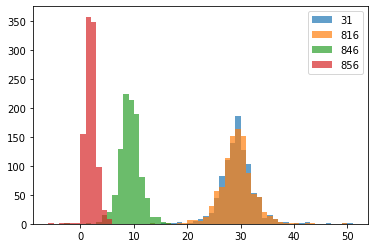

In [30]:
pm, mid = train_model(500,dropout = 0.1,id='sel')
t[mid],s[mid], e[mid] = eval_model(pm, test_ds)
p[mid] = pm

mae = raw_eval(t[mid],s[mid])

run_test(t[mid], s[mid], [31,816,846,856])

idx: 31 t: 31 p: 28
idx: 816 t: 44 p: 28
idx: 846 t: 14 p: 8
idx: 856 t: 4 p: 1


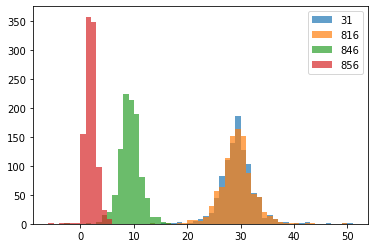

In [31]:
run_test(t[mid], s[mid], [31,816,846,856])

In [33]:
save_full_pitmodel(mid, 'sel', maxgap=65)

make full testdb: 1830 records


Running evaluation: 100%|██████████| 1830/1830 [00:08<00:00, 212.50it/s]


{
    "MSE": 1.4436190187244504,
    "abs_error": 1761.3928558183297,
    "abs_target_sum": 3224.523033324578,
    "abs_target_mean": 1.7620344444396603,
    "seasonal_error": NaN,
    "MASE": NaN,
    "sMAPE": 0.7698763306409333,
    "MSIS": NaN,
    "QuantileLoss[0.1]": 2216.585498575986,
    "Coverage[0.1]": 0.6442622950819672,
    "QuantileLoss[0.5]": 1761.3928558183297,
    "Coverage[0.5]": 0.6885245901639344,
    "QuantileLoss[0.9]": 859.209728979988,
    "Coverage[0.9]": 0.7229508196721312,
    "RMSE": 1.2015069782254493,
    "NRMSE": 0.6818862037668834,
    "ND": 0.5462491157962924,
    "wQuantileLoss[0.1]": 0.6874149992628898,
    "wQuantileLoss[0.5]": 0.5462491157962924,
    "wQuantileLoss[0.9]": 0.2664610300811272,
    "mean_wQuantileLoss": 0.5000417150467699,
    "MAE_Coverage": 0.30327868852459017
}
save model pitmodel-m60-mlp-dsel-e500-l10-10-5-student-d0.1-1k.pickle with 1830 keys.


In [26]:
### run train on all data
trainset, testset, train_ds, test_ds, scaler = _data['all']

pm, mid = train_model(500,dropout = 0.1,id='all')
t[mid],s[mid], e[mid] = eval_model(pm, test_ds)
p[mid] = pm

mae = raw_eval(t[mid],s[mid])

run_test(t[mid], s[mid], [31,816,846,856])
save_full_pitmodel(mid, 'all', maxgap=65)

make full testdb: 1830 records


Running evaluation: 100%|██████████| 1830/1830 [00:10<00:00, 170.78it/s]


{
    "MSE": 0.7731969228788884,
    "abs_error": 1333.656721007439,
    "abs_target_sum": 2966.1651649956075,
    "abs_target_mean": 1.6208552814183648,
    "seasonal_error": NaN,
    "MASE": NaN,
    "sMAPE": 0.6198420666028964,
    "MSIS": NaN,
    "QuantileLoss[0.1]": 546.8604449627725,
    "Coverage[0.1]": 0.44808743169398907,
    "QuantileLoss[0.5]": 1333.656721007439,
    "Coverage[0.5]": 0.7524590163934426,
    "QuantileLoss[0.9]": 760.8667135679584,
    "Coverage[0.9]": 0.7912568306010929,
    "RMSE": 0.8793161677570182,
    "NRMSE": 0.5425013434805563,
    "ND": 0.44962321611292133,
    "wQuantileLoss[0.1]": 0.1843661477170582,
    "wQuantileLoss[0.5]": 0.44962321611292133,
    "wQuantileLoss[0.9]": 0.256515288678837,
    "mean_wQuantileLoss": 0.2968348841696055,
    "MAE_Coverage": 0.23642987249544625
}
save model pitmodel-m60-mlp-dall-e500-l10-10-5-student-d0.1.pickle with 1830 keys.


In [36]:
#save_full_pitmodel(mid, 'sel', maxgap=65)

make full testdb: 2145 records


Running evaluation: 100%|██████████| 2145/2145 [00:10<00:00, 210.37it/s]


{
    "MSE": 1.382760171764095,
    "abs_error": 2034.7206385893026,
    "abs_target_sum": 3779.5638833230714,
    "abs_target_mean": 1.7620344444396603,
    "seasonal_error": NaN,
    "MASE": NaN,
    "sMAPE": 0.7141150368174382,
    "MSIS": NaN,
    "QuantileLoss[0.1]": 2308.3943319916198,
    "Coverage[0.1]": 0.5734265734265734,
    "QuantileLoss[0.5]": 2034.7206385893026,
    "Coverage[0.5]": 0.6144522144522144,
    "QuantileLoss[0.9]": 1291.165687310795,
    "Coverage[0.9]": 0.6480186480186481,
    "RMSE": 1.175908232713801,
    "NRMSE": 0.6673582553533728,
    "ND": 0.5383479950073853,
    "wQuantileLoss[0.1]": 0.6107567971471966,
    "wQuantileLoss[0.5]": 0.5383479950073853,
    "wQuantileLoss[0.9]": 0.34161763821691915,
    "mean_wQuantileLoss": 0.49690747679050035,
    "MAE_Coverage": 0.27995337995337993
}
save model pitmodel-m65-mlp-dsel-e500-l10-10-5-student-d0.1-1k.pickle with 2145 keys.


In [31]:
#mid =  'mlp-dsel-e500-l10-10-5-student-d0.1'
#save_full_pitmodel(mid, 'sel', maxgap=65)
#save_full_pitmodel(mid, 'sel', maxgap=65)

make full testdb: 2145 records


Running evaluation: 100%|██████████| 2145/2145 [00:12<00:00, 174.72it/s]


{
    "MSE": 1.4126874378783432,
    "abs_error": 2116.3819956522934,
    "abs_target_sum": 3779.5638833230714,
    "abs_target_mean": 1.7620344444396603,
    "seasonal_error": NaN,
    "MASE": NaN,
    "sMAPE": 0.7475020353194095,
    "MSIS": NaN,
    "QuantileLoss[0.1]": 2419.7226531269066,
    "Coverage[0.1]": 0.627972027972028,
    "QuantileLoss[0.5]": 2116.3819956522934,
    "Coverage[0.5]": 0.661072261072261,
    "QuantileLoss[0.9]": 1264.6830327334515,
    "Coverage[0.9]": 0.6881118881118881,
    "RMSE": 1.1885652854926998,
    "NRMSE": 0.67454145930199,
    "ND": 0.559954021412525,
    "wQuantileLoss[0.1]": 0.6402121323583598,
    "wQuantileLoss[0.5]": 0.559954021412525,
    "wQuantileLoss[0.9]": 0.3346108365342712,
    "mean_wQuantileLoss": 0.5115923301017187,
    "MAE_Coverage": 0.3003108003108003
}
save model pitmodel-m65-mlp-dsel-e500-l10-10-5-student-d0.1.pickle with 2145 keys.


In [34]:
mid

'mlp-dsel-e500-l10-10-5-student-d0.1'

In [ ]:
sys.exit(0)

### test and tuning

In [ ]:
s.keys()

In [ ]:
pm, mid = train_model(500,dropout = 0.1)
t[mid],s[mid], e[mid] = eval_model(pm)
p[mid] = pm
run_test(t[mid], s[mid], [31,816,846,856])

In [ ]:
run_test(t[mid], s[mid], [31,816,846,856])

In [ ]:
pm, mid = train_model(2000,dropout = 0.1)
t[mid],s[mid], e[mid] = eval_model(pm)
p[mid] = pm
save_model(p[mid], mid)
run_test(t[mid], s[mid], [31,816,846,856])

In [ ]:
mid

In [ ]:
t.keys()

In [ ]:
pm, mid = train_model(200,dropout = 0.1, layers=[8,4])
t[mid],s[mid], e[mid] = eval_model(pm)
p[mid] = pm
run_test(t[mid], s[mid], [31,816,846,856])

In [ ]:
e={}

In [ ]:
t[mid],s[mid], e[mid] = eval_model(pm)
p[mid] = pm
run_test(t[mid], s[mid], [31,816,846,856])

In [ ]:
pm, mid = train_model(500, layers=[10,5])
t[mid],s[mid] = eval_model(pm)
p[mid] = pm

In [ ]:
pm, mid = train_model(500, layers=[32,16,8,4])
t[mid],s[mid] = eval_model(pm)
p[mid] = pm

In [ ]:
run_test(t[mid], s[mid], [31,816,846,856])

In [ ]:
pm, mid = train_model(2000, layers=[32,16,8,4])
t[mid],s[mid] = eval_model(pm)
p[mid] = pm
run_test(t[mid], s[mid], [31,816,846,856])

### test

In [ ]:
trec = next(iter(train_ds))
trec


In [ ]:
run_test(tss, forecasts, [31,816,846,856])

In [ ]:
test_sel.iloc[816]

In [ ]:
test_sel.iloc[836]

In [ ]:
t[mid],s[mid] = eval_model(pm)

In [ ]:
get_pred(t[mid],s[mid], 816)

In [ ]:
next(iter(test_ds))

In [ ]:
scaler

In [ ]:
pm, mid = train_model(2,dropout = 0.1)
#t[mid],s[mid], e[mid] = eval_model(pm)
p[mid] = pm
#run_test(t[mid], s[mid], [31,816,846,856])

#mid = 'mlp-e2000-l10-10-5-student-d0.1'
save_model(p[mid], mid)

### test pitmodel

In [ ]:
_scaler = scaler

In [ ]:
id = 'mlp-e2000-l10-10-5-student-d0.1'
t[id],s[id], e[id] = eval_model(p[id])

In [ ]:
forecasts = s[id]
tss = t[id]

scaler = _scaler
testset = test_sel[['lap2nextpit','caution_laps','pitage']].values

pitmodel = PitModel()

pitmodel.save_model('pitmodel_test', testset, forecasts, scaler)

In [ ]:
newcasts = pitmodel.forecast_ds(testset, forecasts)
scaler = _scaler
run_test(tss, newcasts, [31,816,846,856],raw_forecast=True)

In [ ]:
plt.plot(pitmodel.model['0-0'][0,:], pitmodel.model['0-0'][1,:])

In [ ]:
plt.plot(pitmodel.model['10-13'][0,:], pitmodel.model['10-13'][1,:])

In [ ]:
pitmodel.model['0-0'][0,:]

In [ ]:
scaler = _scaler
test_all = df_test[['lap2nextpit','caution_laps','pitage']].values
test_ds, _, test_set = makedb(test_all, scaler, perm=False)

id = 'mlp-e2000-l10-10-5-student-d0.1'
t[id],s[id], e[id] = eval_model(p[id])
forecasts = s[id]
tss = t[id]

pitmodel = PitModel()

pitmodel.save_model(f'mlp-{id}.pickle', test_all, forecasts, scaler)


In [ ]:
len(forecasts)

In [ ]:
testall_set

In [ ]:
scaler = _scaler
maxgap = 60
test_ds, _, test_set, test_all = make_fulltestdb(scaler, maxgap = maxgap)

id = 'mlp-e2000-l10-10-5-student-d0.1'

t[id],s[id], e[id] = eval_model(p[id])
forecasts = s[id]
tss = t[id]

pitmodel = PitModel()

pitmodel.save_model(f'pitmodel-m{maxgap}-{id}.pickle', test_all, forecasts, scaler)

In [ ]:
pitmodel.model['0-0'][0,:]

In [ ]:
plt.plot(pitmodel.model['0-0'][0,:], pitmodel.model['0-0'][1,:])

In [ ]:
t.keys()

In [ ]:
t['mlp-dsel-e500-l10-10-5-student-d0.1'][0]

### shortterm predictions using pitmodel(plen=2)

convert forecast samples of pitmodel to forecast samples of pit@plen laps

In [18]:
test_car12 = df_test[df_test['carno']==12]

In [19]:
test_ds, _, test_set = makedb(test_car12[['lap2nextpit','caution_laps','pitage']].values, scaler, perm=False)

In [20]:
len(test_set)

170

In [21]:
test

array([[ 1.88149958, -0.70945244, -1.40995345],
       [ 1.76852039, -0.70945244, -1.29736294],
       [ 1.6555412 , -0.70945244, -1.18477243],
       [ 1.54256201, -0.70945244, -1.07218192],
       [ 1.42958282, -0.70945244, -0.95959142],
       [ 1.31660363, -0.70945244, -0.84700091],
       [ 1.20362444, -0.70945244, -0.7344104 ],
       [ 1.09064525, -0.70945244, -0.62181989],
       [ 0.97766607, -0.70945244, -0.50922938],
       [ 0.86468688, -0.70945244, -0.39663887],
       [ 0.75170769, -0.70945244, -0.28404836],
       [ 0.6387285 , -0.70945244, -0.17145786],
       [ 0.52574931, -0.70945244, -0.05886735],
       [ 0.41277012, -0.70945244,  0.05372316],
       [ 0.29979093, -0.70945244,  0.16631367],
       [ 0.18681174, -0.70945244,  0.27890418],
       [ 0.07383255, -0.70945244,  0.39149469],
       [-0.03914664, -0.70945244,  0.5040852 ],
       [-0.15212582, -0.70945244,  0.6166757 ],
       [-0.26510501, -0.70945244,  0.72926621],
       [-0.3780842 , -0.70945244,  0.841

In [23]:
test_car12[test_car12['lap']==31]

,lap2nextpit,caution_laps,pitage,pit_oncaution,carno,eid,lap,stint_len
1059,18.0,0.0,0.0,1.0,12,5,31,18.0


In [24]:
test_car12[test_car12['lap']==30]

,lap2nextpit,caution_laps,pitage,pit_oncaution,carno,eid,lap,stint_len
1058,1.0,0.0,31.0,0.0,12,5,30,31.0


In [25]:
test_ds

[{'target': array([1.88149958]),
  'feat': array([-0.70945244, -1.40995345]),
  'start': Timestamp('2019-01-01 00:00:00', freq='T'),
  'forecast_start': Timestamp('2019-01-01 00:00:00', freq='T')},
 {'target': array([1.76852039]),
  'feat': array([-0.70945244, -1.29736294]),
  'start': Timestamp('2019-01-01 00:00:00', freq='T'),
  'forecast_start': Timestamp('2019-01-01 00:00:00', freq='T')},
 {'target': array([1.6555412]),
  'feat': array([-0.70945244, -1.18477243]),
  'start': Timestamp('2019-01-01 00:00:00', freq='T'),
  'forecast_start': Timestamp('2019-01-01 00:00:00', freq='T')},
 {'target': array([1.54256201]),
  'feat': array([-0.70945244, -1.07218192]),
  'start': Timestamp('2019-01-01 00:00:00', freq='T'),
  'forecast_start': Timestamp('2019-01-01 00:00:00', freq='T')},
 {'target': array([1.42958282]),
  'feat': array([-0.70945244, -0.95959142]),
  'start': Timestamp('2019-01-01 00:00:00', freq='T'),
  'forecast_start': Timestamp('2019-01-01 00:00:00', freq='T')},
 {'target':

In [26]:
len(test_ds)

170

In [28]:
test_set

array([[ 1.88149958, -0.70945244, -1.40995345],
       [ 1.76852039, -0.70945244, -1.29736294],
       [ 1.6555412 , -0.70945244, -1.18477243],
       [ 1.54256201, -0.70945244, -1.07218192],
       [ 1.42958282, -0.70945244, -0.95959142],
       [ 1.31660363, -0.70945244, -0.84700091],
       [ 1.20362444, -0.70945244, -0.7344104 ],
       [ 1.09064525, -0.70945244, -0.62181989],
       [ 0.97766607, -0.70945244, -0.50922938],
       [ 0.86468688, -0.70945244, -0.39663887],
       [ 0.75170769, -0.70945244, -0.28404836],
       [ 0.6387285 , -0.70945244, -0.17145786],
       [ 0.52574931, -0.70945244, -0.05886735],
       [ 0.41277012, -0.70945244,  0.05372316],
       [ 0.29979093, -0.70945244,  0.16631367],
       [ 0.18681174, -0.70945244,  0.27890418],
       [ 0.07383255, -0.70945244,  0.39149469],
       [-0.03914664, -0.70945244,  0.5040852 ],
       [-0.15212582, -0.70945244,  0.6166757 ],
       [-0.26510501, -0.70945244,  0.72926621],
       [-0.3780842 , -0.70945244,  0.841